<h1><center>Indoor Location & Navigation</h1></center>
<h2><center>Identify the position of a smartphone in a shopping mall</h2></center>

<b>In this notebook I have tried my best to explain all the topics/aspects, related to this competition, at easiest form. </b>

<center><img src ="http://static.dist10.cn/Fh7Zz-ipJRPZRM9bE1p7Dsu7YLpJ/section3_bg.png?imageView2/5/w/1440/h/600 " width = "800" height = "800"/></center>   

<center><h2>Understand The Competition</center></h2>
Our smartphone goes everywhere with us and with permission, apps can use our location to provide contextual information. We get driving directions, find a store, or receive alerts for nearby promotions. These handy features are enabled by GPS, which requires outdoor exposure for the best accuracy.

Current positioning solutions have poor accuracy, particularly in multi-level buildings.

<b>In this competition, our task is to predict the indoor position of smartphones based on real-time sensor data.</b>

In [ ]:
# Libraries
import numpy as np # linear algebra
import pandas as pd # data processing
import os
import json
import random
import glob
import seaborn as sns
from pathlib import Path
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import KFold
import lightgbm as lgb
import psutil
import random
import os
import time
import sys
import math
from contextlib import contextmanager

<h2><center>Data Exploration and Data Understanding (EDA)</h2></center>
<center><img src ="https://luminousmen.com/media/exploratory-data-analysis.jpg " width = "400" height = "400"/></center>   



<b>In this section, I will drive you through all the important aspects of Data so that we can understand the Data which is the most important thing to ace the competition.</b>

<h2>Understand the Data</h2>
First, we need to understand the input data. The folder "indoor-location-navigation" contains 3 subdirectories, "metadata", "test", and "train", respectively.
The following schematic shows the data structure in the "metadata" folder, as it is given in the "Data Description" tab.

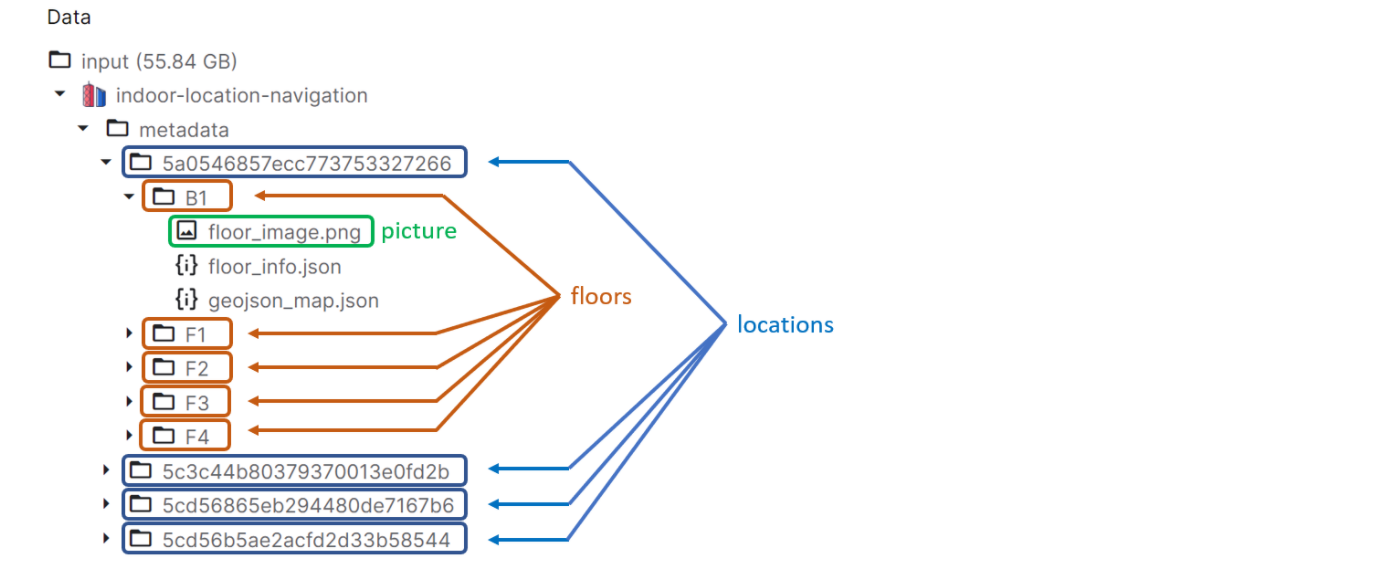

We are going to use the images in the .png format to display the locations. The other two files associated with each floor are in .json format. The floor_info.json describes the size of the location (height and width), while the geojson_map.json is a file for geospatial visualization (it is possible to reproduce a raster image in .png format using the *geopandas* library applied to this .json file).

<h2>Data Organization</h2>

<h4>Training Dataset</h4>

In [ ]:
dataset_path = Path('../input/indoor-location-navigation')
os.listdir(dataset_path)

<b>Note that the data is organized by the sites and floors. Let's see how many sites do we have in train dataset?</b>

In [ ]:
train_sites = os.listdir(dataset_path/"train")
print(f'There are {len(train_sites)} sites in the training set')

<b>Now each site is organized by Floors</b>

In [ ]:
example_site = os.listdir(dataset_path/"train")[10]
example_site_path = dataset_path/"train"/example_site
print('Floors for example site:')
print(os.listdir(example_site_path))

In [ ]:
floors_per_site = []
for i in os.listdir(dataset_path/"train"): floors_per_site.append(len(os.listdir(dataset_path/"train"/i)))
print(f'There are a total of {sum(floors_per_site)} floors. On average, each site has {np.mean(floors_per_site)} floors')

<b>So every site has about 5 floors. In each floor are the path trace text files with the data</b>

<b>Path File</b>

In [ ]:
print('Path text files for example floor:')
print(os.listdir(example_site_path/'B1'))

<h4>Train Data path files count</h4>

In [ ]:
print(f"There are {len(list((dataset_path/'train').rglob('*.txt')))} path text files in the training set")

<b>To summarize, this is how the training data is structured:</b>



```
└───train                                                        //raw data from two sites
      └───site1
      |     └───B1                                               //traces from one floor
      |     |   └───5dda14a2c5b77e0006b17533.txt                 //trace file                             
      |     |   | ...
      |     |
      |     |
      |     └───F1
      |     | ...
      |
      └───site2
```

<h4>Test Dataset</h4>

In [ ]:
print(f"There are {len(os.listdir(dataset_path/'test'))} path text files in the test set")

<h4>Metdata Organization</h4>

In [ ]:
print(f'There are {len(os.listdir(dataset_path/"metadata"))} sites in the metadata, just like the training set')

<b>Let's look at a single floor of a single site</b>

In [ ]:
metadata_example_site = os.listdir(dataset_path/"metadata")[10]
metadata_example_site_path = dataset_path/"metadata"/metadata_example_site
metadata_example_floor_path = dataset_path/"metadata"/metadata_example_site/os.listdir(metadata_example_site_path)[0]
print(os.listdir(metadata_example_floor_path))

<b>Explore 'floor_image.png' file</b>

In [ ]:
Image.open(metadata_example_floor_path/'floor_image.png')

<b>Explore 'geojson_map.json' file</b>

In [ ]:
##################### In comment because Large Output Data ########################


# with open(metadata_example_floor_path/'geojson_map.json') as geojson_map:
#     data = json.load(geojson_map)
#     geojson_map.close()
# print(data)

<b>Explore 'floor_info.json' file</b>

In [ ]:
with open(metadata_example_floor_path/'floor_info.json') as floor_info:
    data = json.load(floor_info)
    floor_info.close()
print(data)


<h3>Path text files</h3>
<b>Brief here. Each Column is described in detail in session (Deep Dive) below</b>
<p></p>
Let's look more closely at the path text files and how to process them.

The [GitHub README](https://github.com/location-competition/indoor-location-competition-20) provides more information about the text file format:

> The first column is Unix Time in millisecond. In specific, we use SensorEvent.timestamp for sensor data and system time for WiFi and Bluetooth scans.
> 
>The second column is the data type (ten in total).
>
>TYPE_ACCELEROMETER
>
>TYPE_MAGNETIC_FIELD
>
>TYPE_GYROSCOPE
>
>TYPE_ROTATION_VECTOR
>
>TYPE_MAGNETIC_FIELD_UNCALIBRATED
>TYPE_GYROSCOPE_UNCALIBRATED
>
>TYPE_ACCELEROMETER_UNCALIBRATED
>
>TYPE_WIFI
>
>TYPE_BEACON
>
>TYPE_WAYPOINT: ground truth location labeled by the surveyor
>
>Data values start from the third column.
>
>Column 3-5 of TYPE_ACCELEROMETER、TYPE_ACCELEROMETER、TYPE_GYROSCOPE、TYPE_ROTATION_VECTOR are SensorEvent.values[0-2] from the callback function onSensorChanged(). Column 6 is SensorEvent.accuracy.
>
>Column 3-8 of TYPE_ACCELEROMETER_UNCALIBRATED、TYPE_GYROSCOPE_UNCALIBRATED、TYPE_MAGNETIC_FIELD_UNCALIBRATED are SensorEvent.values[0-5] from the callback function onSensorChanged(). Column 9 is SensorEvent.accuracy.

<b>Let's Explore Text File</b>

In [ ]:
example_floor_path = example_site_path/'B1'
example_txt_path = example_floor_path/os.listdir(example_floor_path)[0]
with open(example_txt_path) as example_txt:
    data = example_txt.read()
    example_txt.close()

##################### In comment because Large Output Data ########################
# print(data)

<h2><center>Deep Dive into EDA</h2>

<center><img src ="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRSq7tFWVYNmxhjebh_havbaBkI5UmrewSEKw&usqp=CAU " width = "400" height = "400"/></center>  

<h4>Define some Functions/Tools that we will use for EDA</h4>

In [ ]:
def load_trace_as_dataframe(filepath):
    # Returns trace dataframe sorted by timestamp
    
    names = ['time', 'type'] + [f'col_{i}' for i in range(1, 9)]
    
    trace_df = pd.read_csv(
        filepath, sep='\t', comment='#', header=None, names=names
    )
    
    trace_df.sort_values(by='time', inplace=True)
    trace_df.reset_index(drop=True, inplace=True)
    return trace_df

In [ ]:
def extract_feature_df(trace_df, 
                       feature_name, 
                       col_names=('x', 'y', 'z', 'accuracy')):
    
    
#     Extracts feature dataframe from trace dataframe by feature name.
    
#     Suitable for features: 
#     ----------------------
#         TYPE_WAYPOINT, if set col_names=('x', 'y'),
#         TYPE_ACCELEROMETER,
#         TYPE_GYROSCOPE,
#         TYPE_MAGNETIC_FIELD, 
#         TYPE_ROTATION_VECTOR,
        
#         TYPE_ACCELEROMETER_UNCALIBRATED, 
#                     if set col_names=('x', 'y', 'z', 'x_2', 'y_2', 'z_2', 'accuracy'),
                    
#         TYPE_GYROSCOPE_UNCALIBRATED, 
#                     if set col_names=('x', 'y', 'z', 'x_2', 'y_2', 'z_2', 'accuracy'),
                    
#         TYPE_MAGNETIC_FIELD_UNCALIBRATED, 
#                     if set col_names=('x', 'y', 'z', 'x_2', 'y_2', 'z_2', 'accuracy')
    
    
    feature_df = trace_df[trace_df['type'] == feature_name].copy()
    for i, col in enumerate(col_names, start=1):
        feature_df[col] = feature_df[f'col_{i}'].astype('float64')
        
    feature_df.drop(columns=[f'col_{i}' for i in range(1, 9)], inplace=True)
    feature_df.drop(columns=['type'], inplace=True)
    feature_df.reset_index(drop=True, inplace=True)
    
    return feature_df

In [ ]:
def load_points(filepath):
    # Takes the path to the trace file.
    # Returns pandas dataframe which consists of device locations 
    # as x and y coordinates (values from TYPE_WAYPOINT) and their timestamps.
    
    trace_df = load_trace_as_dataframe(filepath)
    points_df = extract_feature_df(
        trace_df, 'TYPE_WAYPOINT', col_names=('x', 'y')
    )
    
    return points_df

In [ ]:
def visualize_many_traces_on_the_map(traces_dataframes, map_image, width, height, 
                                     traces_filenames=None, 
                                     figsize=None):
    

#     Draws traces on the floor map.
    
#     Parameters
#     ----------
#         traces_dataframes: list of pandas DataFrames
#             Each DataFrame should consist of device locations as x and y 
#             coordinates and their timestamps.

#         map_image : numpy.array
#             Image of floor map.

#         width : float,
#             Width of floor. Should be taken from floor_info.json

#         height : float, 
#             Height of floor. Should be taken from floor_info.json

#         traces_filenames : list of strings, optional, default: None
#             List of filenames. Used to display the legend. 
#             There will be no legend if you pass traces_filenames=None

#         figsize : (float, float), optional, default: None
#             Size of the result image in terms of matplotlib.
    

    
    fig = plt.figure(figsize=figsize)
    ax = plt.subplot(111)

    plt.imshow(map_image, extent=[0, width, 0, height])

    if traces_filenames:
        
        for filename, points in zip(traces_filenames, traces_dataframes):
            plt.scatter(points['x'], points['y'], label=filename)
            plt.plot(points['x'], points['y'])
            
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        for points in traces_dataframes:
            plt.scatter(points['x'], points['y'])
            plt.plot(points['x'], points['y'])


    plt.show()

In [ ]:
def visualize_single_trace_on_the_map(points_df, map_image, width, height, 
                                      scaling_coef=0.3, figsize=None):
    
    
#     Draws single trace on the floor map.
    
#     Parameters
#     ----------
#         points_df: pandas DataFrame
#             Should consist of device locations as x and y 
#             coordinates and their timestamps.

#         map_image : numpy.array
#             Image of floor map.

#         width : float,
#             Width of floor. Should be taken from floor_info.json

#         height : float, 
#             Height of floor. Should be taken from floor_info.json

#         scaling_coef : float
#             Scaling Coefficient. 

#         figsize : (float, float), optional, default: None
#             Size of the result image in terms of matplotlib.
    
    
    
    fig = plt.figure(figsize=figsize)
    ax = plt.subplot(111)

    plt.imshow(map_image, extent=[0, width, 0, height])
    plt.plot(points_df['x'], points_df['y'], linewidth=5, linestyle='-', color='blue')

    for i in range(len(points_df)):
        ax.text(
            points_df.loc[i, 'x'], points_df.loc[i, 'y'], i, 
            ha="center", size=15, 
            bbox=dict(boxstyle="circle, pad=0.3", 
                      fc="cyan", lw=2)
        )
 
    x_min, x_max = points_df['x'].min(), points_df['x'].max()
    y_min, y_max = points_df['y'].min(), points_df['y'].max()

    ax.set_xlim(x_min - scaling_coef*(x_max - x_min), x_max + scaling_coef*(x_max - x_min))
    ax.set_ylim(y_min - scaling_coef*(y_max - y_min), y_max + scaling_coef*(y_max - y_min))

    plt.show()


In [ ]:
def plot_trace_features(feature_df, timestamps=None, figsize=None):
    

#     Plots the trace features.
    
#     Parameters
#     ----------
#         feature_df : pandas DataFrame
#             Can be exctracted from trace dataframe 
#             using extract_feature_df function.
        
#         timestamps : array-like, optional, default: None
#             Array of timestamps. 
#             Used to mark timestamps on the chart in the form of vertical lines.
#             Pass timestamps=None if you don't want to use this feature.

#         figsize : (float, float), optional, default: None
#             Size of the result image in terms of matplotlib.
    
#     Suitable for features: 
#     ----------------------
#         TYPE_ACCELEROMETER 
#         TYPE_GYROSCOPE 
#         TYPE_MAGNETIC_FIELD 
#         TYPE_ROTATION_VECTOR 
#         TYPE_ACCELEROMETER_UNCALIBRATED 
#         TYPE_GYROSCOPE_UNCALIBRATED 
#         TYPE_MAGNETIC_FIELD_UNCALIBRATED
   
    
    fig = plt.figure(figsize=figsize)
    ax = plt.subplot(111)

    for col in ['x', 'y', 'z']:
        plt.plot(feature_df['time'], feature_df[col], label=col)


    if points_df is not None:
        xmin, xmax, ymin, ymax = plt.axis()

        for i, timestamp in enumerate(timestamps):
            plt.axvline(x=timestamp, c='k', ls='--')

            ax.text(
            timestamp, ymax, i, 
            ha="center", size=15, 
            bbox=dict(boxstyle="circle, pad=0.3", 
                      fc="white", lw=2)
            )
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [ ]:
data_path = '/kaggle/input/indoor-location-navigation'
floor = '5a0546857ecc773753327266/F1'
floor_metadata_dir = os.path.join(data_path, 'metadata', floor)
floor_train_dir = os.path.join(data_path, 'train', floor)

<h4>Loading coordinates of paths points</h4>

In [ ]:
paths = []
for filename in os.listdir(floor_train_dir):
    if '.txt' not in filename:
        continue
    points = load_points(os.path.join(floor_train_dir, filename))
    paths.append((filename, points))

paths = sorted(paths, key=lambda path: len(path[1]), reverse=True)
paths = paths[:20]


traces_dataframes = [trace for filename, trace in paths]
traces_filenames = [filename for filename, trace in paths]

<h4>Loading floor map and its size</h4>

In [ ]:
MAP_IMAGE = plt.imread(
    os.path.join(floor_metadata_dir, 'floor_image.png')
)

with open(os.path.join(floor_metadata_dir, 'floor_info.json')) as f:
    content = f.read()
    floor_info = json.loads(content)

MAP_HEIGHT = float(floor_info['map_info']['height'])
MAP_WIDTH = float(floor_info['map_info']['width'])
    
floor_info

<h4>Visualization of Traces (Paths) on the Floor Map</h4>

In [ ]:
visualize_many_traces_on_the_map(
    traces_dataframes, MAP_IMAGE, MAP_WIDTH, MAP_HEIGHT, 
    traces_filenames=traces_filenames, 
    figsize=(15, 12)
)

<h4>Features Visualization</h4>
Let's take a closer look at single trace (path) and its attributes.

In [ ]:
filename='5e15b0171506f2000638fe49.txt'
trace_filepath = os.path.join(floor_train_dir, filename)

trace_df = load_trace_as_dataframe(trace_filepath)
trace_df

Here is a table of the attributes we need to deal with in this competition. 

As you can see it contains feature names and its params. We will describe some of these features in more detail below.

Each feature can be extracted from trace as dataframe with params as columns. For this we are using function `extract_feature_df` which is suitable for all features except TYPE_WIFI and TYPE_BEACON.

The table is taken from [competition's official github repo](https://github.com/location-competition/indoor-location-competition-20).

| Feature                           | Values |       |        |        |                   |        |           |                                   |
|:----------------------------------|:------:|:-----:|:------:|:-------|:-----------------:|:------:|:---------:|:---------------------------------:|
|TYPE_WAYPOINT                      |X axis  |Y axis |       |         |                   |        |           |                                   |
|TYPE_ACCELEROMETER                 |X axis  |Y axis |Z axis |accuracy |                   |        |           |                                   |
|TYPE_GYROSCOPE                     |X axis  |Y axis |Z axis |accuracy |                   |        |           |                                   | 
|TYPE_MAGNETIC_FIELD                |X axis  |Y axis |Z axis |accuracy |                   |        |           |                                   | 
|TYPE_ROTATION_VECTOR               |X axis  |Y axis |Z axis |accuracy |                   |        |           |                                   |
|TYPE_ACCELEROMETER_UNCALIBRATED    |X axis  |Y axis |Z axis |X axis   |Y axis             |Z axis  |accuracy   |                                   |
|TYPE_GYROSCOPE_UNCALIBRATED        |X axis  |Y axis |Z axis |X axis   |Y axis             |Z axis  |accuracy   |                                   |
|TYPE_MAGNETIC_FIELD_UNCALIBRATED   |X axis  |Y axis |Z axis |X axis   |Y axis             |Z axis  |accuracy   |                                   |
|TYPE_WIFI                          |ssid    |bssid  |RSSI   |frequency|last seen timestamp|        |           |                                   |
|TYPE_BEACON                        |UUID    |MajorID|MinorID|Tx Power |RSSI               |Distance|MAC Address|same with Unix time, padding data  |
​

<b>TYPE_WAYPOINT</b>

In [ ]:
points_df = extract_feature_df(trace_df, 'TYPE_WAYPOINT', col_names=('x', 'y'))
points_df.head()

In [ ]:
visualize_single_trace_on_the_map(
    points_df, MAP_IMAGE, MAP_WIDTH, MAP_HEIGHT, figsize=(10, 8)
)

<b>TYPE_ACCELEROMETER</b>

In [ ]:
acc_df = extract_feature_df(trace_df, 'TYPE_ACCELEROMETER')
acc_df.head()

In [ ]:
sns.pairplot(acc_df[['x', 'y', 'z']])
plt.show()

<b>TYPE_GYROSCOPE</b>

In [ ]:
gyro_df = extract_feature_df(trace_df, 'TYPE_GYROSCOPE')
gyro_df.head()

<b>TYPE_MAGNETIC_FIELD</b>

In [ ]:
magn_df = extract_feature_df(trace_df, 'TYPE_MAGNETIC_FIELD')
magn_df.head()

<b>TYPE_ROTATION_VECTOR</b>

In [ ]:
rot_df = extract_feature_df(trace_df, 'TYPE_ROTATION_VECTOR')
rot_df.head()

In [ ]:
sns.pairplot(rot_df[['x', 'y', 'z']])
plt.show()

<h2><center>Baseline Model 1</h2></center>
<center><img src ="https://lightgbm.readthedocs.io/en/latest/_images/LightGBM_logo_black_text.svg " width = "400" height = "400"/></center> 

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path
import glob

from sklearn.model_selection import KFold
import lightgbm as lgb

import psutil
import random
import os
import time
import sys
import math
from contextlib import contextmanager

In [ ]:
N_SPLITS = 20
SEED = 1234

Get file path from kaggle 

In [ ]:
LOG_PATH = Path("./log/")
LOG_PATH.mkdir(parents=True, exist_ok=True)

Some utility code

1. A timer
2. A seed setter
3. A intermediate metric finder
4. A score logger

In [ ]:
@contextmanager
def timer(name: str):
    t0 = time.time()
    p = psutil.Process(os.getpid())
    m0 = p.memory_info()[0] / 2. ** 30
    try:
        yield
    finally:
        m1 = p.memory_info()[0] / 2. ** 30
        delta = m1 - m0
        sign = '+' if delta >= 0 else '-'
        delta = math.fabs(delta)
        print(f"[{m1:.1f}GB({sign}{delta:.1f}GB): {time.time() - t0:.3f}sec] {name}", file=sys.stderr)


def set_seed(seed=1234):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

    
def comp_metric(xhat, yhat, fhat, x, y, f):
    intermediate = np.sqrt(np.power(xhat-x, 2) + np.power(yhat-y, 2)) + 15 * np.abs(fhat-f)
    return intermediate.sum()/xhat.shape[0]


def score_log(df: pd.DataFrame, num_files: int, nam_file: str, data_shape: tuple, n_fold: int, seed: int, mpe: float):
    score_dict = {'n_files': num_files, 'file_name': nam_file, 'shape': data_shape, 'fold': n_fold, 'seed': seed, 'score': mpe}
    # noinspection PyTypeChecker
    df = pd.concat([df, pd.DataFrame.from_dict([score_dict])])
    df.to_csv(LOG_PATH / f"log_score.csv", index=False)
    return df


Get all the data in our nb env

In [ ]:
set_seed(SEED)
feature_dir = "../input/indoor-navigation-and-location-wifi-features"
train_files = sorted(glob.glob(os.path.join(feature_dir, '*_train.csv')))
test_files = sorted(glob.glob(os.path.join(feature_dir, '*_test.csv')))
subm = pd.read_csv('../input/indoor-location-navigation/sample_submission.csv', index_col=0)

Create some tuned paratmeters for the LGB ( These will be tweaked to get the best performance)

In [ ]:
lgb_params = {'objective': 'root_mean_squared_error',
              'boosting_type': 'gbdt',
              'n_estimators': 50000,
              'learning_rate': 0.1,
              'num_leaves': 90,
              'colsample_bytree': 0.4,
              'subsample': 0.6,
              'subsample_freq': 2,
              'bagging_seed': SEED,
              'reg_alpha': 8,
              'reg_lambda': 2,
              'random_state': SEED,
              'n_jobs': -1
              }

lgb_f_params = {'objective': 'multiclass',
                'boosting_type': 'gbdt',
                'n_estimators': 50000,
                'learning_rate': 0.1,
                'num_leaves': 90,
                'colsample_bytree': 0.4,
                'subsample': 0.6,
                'subsample_freq': 2,
                'bagging_seed': SEED,
                'reg_alpha': 10,
                'reg_lambda': 2,
                'random_state': SEED,
                'n_jobs': -1
                }

Splitting the data into train and validation and passed them through LGBm and then ssaving the predicitions into pred

<b>Below is Light GBM code. Commented because very large output.</b>

In [ ]:
# score_df = pd.DataFrame()
# oof = list()
# predictions = list()
# for n_files, file in enumerate(train_files):
#     data = pd.read_csv(file, index_col=0)
#     test_data = pd.read_csv(test_files[n_files], index_col=0)

#     oof_x, oof_y, oof_f = np.zeros(data.shape[0]), np.zeros(data.shape[0]), np.zeros(data.shape[0])
#     preds_x, preds_y = 0, 0
#     preds_f_arr = np.zeros((test_data.shape[0], N_SPLITS))

#     kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
#     for fold, (trn_idx, val_idx) in enumerate(kf.split(data.iloc[:, :-4])):
#         X_train = data.iloc[trn_idx, :-4]
#         y_trainx = data.iloc[trn_idx, -4]
#         y_trainy = data.iloc[trn_idx, -3]
#         y_trainf = data.iloc[trn_idx, -2]

#         X_valid = data.iloc[val_idx, :-4]
#         y_validx = data.iloc[val_idx, -4]
#         y_validy = data.iloc[val_idx, -3]
#         y_validf = data.iloc[val_idx, -2]

#         modelx = lgb.LGBMRegressor(**lgb_params)
#         with timer("fit X"):
#             modelx.fit(X_train, y_trainx,
#                        eval_set=[(X_valid, y_validx)],
#                        eval_metric='rmse',
#                        verbose=True,
#                        early_stopping_rounds=5
#                        )

#         modely = lgb.LGBMRegressor(**lgb_params)
#         with timer("fit Y"):
#             modely.fit(X_train, y_trainy,
#                        eval_set=[(X_valid, y_validy)],
#                        eval_metric='rmse',
#                        verbose=True,
#                        early_stopping_rounds=5
#                        )
#         modelf = lgb.LGBMClassifier(**lgb_f_params)
#         with timer("fit F"):
#             modelf.fit(X_train, y_trainf,
#                        eval_set=[(X_valid, y_validf)],
#                        eval_metric='multi_logloss',
#                        verbose=True,
#                        early_stopping_rounds=5
#                        )

#         oof_x[val_idx] = modelx.predict(X_valid)
#         oof_y[val_idx] = modely.predict(X_valid)
#         oof_f[val_idx] = modelf.predict(X_valid).astype(int)

#         preds_x += modelx.predict(test_data.iloc[:, :-1]) / N_SPLITS
#         preds_y += modely.predict(test_data.iloc[:, :-1]) / N_SPLITS
#         preds_f_arr[:, fold] = modelf.predict(test_data.iloc[:, :-1]).astype(int)

#         score = comp_metric(oof_x[val_idx], oof_y[val_idx], oof_f[val_idx],
#                             y_validx.to_numpy(), y_validy.to_numpy(), y_validf.to_numpy())
#         print(f"fold {fold}: mean position error {score}")
#         score_df = score_log(score_df, n_files, os.path.basename(file), data.shape, fold, SEED, score)

#     print("*+"*40)
#     print(f"file #{n_files}, shape={data.shape}, name={os.path.basename(file)}")
#     score = comp_metric(oof_x, oof_y, oof_f,
#                         data.iloc[:, -4].to_numpy(), data.iloc[:, -3].to_numpy(), data.iloc[:, -2].to_numpy())
#     oof.append(score)
#     print(f"mean position error {score}")
#     print("*+"*40)
#     score_df = score_log(score_df, n_files, os.path.basename(file), data.shape, 999, SEED, score)

#     preds_f_mode = stats.mode(preds_f_arr, axis=1)
#     preds_f = preds_f_mode[0].astype(int).reshape(-1)
#     test_preds = pd.DataFrame(np.stack((preds_f, preds_x, preds_y))).T
#     test_preds.columns = subm.columns
#     test_preds.index = test_data["site_path_timestamp"]
#     test_preds["floor"] = test_preds["floor"].astype(int)
#     predictions.append(test_preds)

Save the predictions into the same format as required 

In [ ]:
# all_preds = pd.concat(predictions)
# all_preds = all_preds.reindex(subm.index)
# all_preds.to_csv('submission.csv')
# all_preds.head(20)

<h3>Refrences</h3>


https://www.kaggle.com/harshsharma511/indoor-location-navigation-eda

https://www.kaggle.com/harshsharma511/basic-eda-traces-and-features-visualization

https://www.kaggle.com/harshsharma511/lightgbm-regressor